# CIFAR-10 Differential Attack

## Configuration

In [1]:
import os

import numpy as np
import tensorflow as tf

In [2]:
FILE_PATH = os.getcwd()
MODEL_PATH = os.path.join(FILE_PATH, "../models/my_vgg.h5")
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

## Dataset preparation

We work with categorical (binary class matrix) instead of class vectors (integers).

In [3]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def __prepare_datasets():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return (x_train, y_train), (x_test, y_test)

In [4]:
data_train, data_test = __prepare_datasets()
x_train, y_train = data_train
x_test, y_test = data_test
print(f"x_train.shape = {x_train.shape} y_train.shape = {y_train.shape}")
print(f"x_test.shape = {x_test.shape} y_test.shape = {y_test.shape}")

x_train.shape = (50000, 32, 32, 3) y_train.shape = (50000, 10)
x_test.shape = (10000, 32, 32, 3) y_test.shape = (10000, 10)


## Model preparation

We use our own VGG model.

In [5]:
from integration_tests.models.my_vgg import my_vgg

def __prepare_model(data_train, data_test):
    if os.path.exists(MODEL_PATH):
        print("---Using Existing Model---")
        model: tf.keras.Model = tf.keras.models.load_model(MODEL_PATH)
    else:
        print("---Training Model---")
        print(f"GPU IS AVAILABLE: {tf.config.list_physical_devices('GPU')}")
        model: tf.keras.Model = my_vgg()
        model.fit(
            *data_train,
            epochs=100,
            batch_size=64,
            validation_data=data_test,
        )
        model.save(MODEL_PATH)

    model.summary()
    return model

In [6]:
model = __prepare_model(data_train, data_test)

---Using Existing Model---
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            

## Look for fragile images

(Images that can be easily missclassified.)

In [7]:
def __find_fragile_images(
    data_test: np.ndarray,
    model: tf.keras.Model,
    fragility_threshold=0.1,
):
    """Look for images which are sensible to FI.

    "Fragile image" has these conditions :

    -  y_pred_index == y_true_index
    -  std(y_pred) < fragility_threshold
    """
    x_test, y_test = data_test
    result = model.predict(x_test)

    for i, y_pred in enumerate(result):
        y_true = y_test[i]
        y_true_index = np.argmax(y_true)
        y_pred_index = np.argmax(y_pred)

        if (
            y_pred_index == y_true_index
            and np.std(y_pred) < fragility_threshold
        ):
            print(
                f"image {i} is fragile.\n"
                f"std: {np.std(y_pred)}.\n"
                f"y_pred[y_true_index]={y_pred[y_true_index]}\n"
                f"y_pred[0]={y_pred[0]}\n"
            )
            yield i

In [8]:
fragile_imgs = list(__find_fragile_images(data_test, model))

image 629 is fragile.
std: 0.08297225087881088.
y_pred[y_true_index]=0.3010726869106293
y_pred[0]=0.11562445014715195

image 878 is fragile.
std: 0.09110098332166672.
y_pred[y_true_index]=0.28201019763946533
y_pred[0]=0.14032000303268433

image 1975 is fragile.
std: 0.09571870416402817.
y_pred[y_true_index]=0.2684406340122223
y_pred[0]=0.18283182382583618

image 2032 is fragile.
std: 0.0846942886710167.
y_pred[y_true_index]=0.2672123312950134
y_pred[0]=0.022510046139359474

image 4282 is fragile.
std: 0.09785398095846176.
y_pred[y_true_index]=0.2889142632484436
y_pred[0]=0.04903290793299675

image 4705 is fragile.
std: 0.08988039195537567.
y_pred[y_true_index]=0.2513140141963959
y_pred[0]=0.1394633948802948

image 5700 is fragile.
std: 0.08809789270162582.
y_pred[y_true_index]=0.3044825792312622
y_pred[0]=0.027622321620583534

image 6083 is fragile.
std: 0.07141569256782532.
y_pred[y_true_index]=0.27099087834358215
y_pred[0]=0.13926005363464355

image 6729 is fragile.
std: 0.0890604481

## Differential Attack

Our implementations is based on [github.com/Hyperparticle/one-pixel-attack-keras](https://github.com/Hyperparticle/one-pixel-attack-keras).

```python
def original_perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can
    # create n new perturbed images
    tile = [len(xs)] + [1] * (xs.ndim + 1)
    imgs = np.tile(img, tile)

    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)

    for x, img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb

    return imgs


def predict_classes(
    xs: np.ndarray, img: np.ndarray, y_true: int, model: tf.keras.Model
) -> np.ndarray:
    """Perturb the image and get the predictions of the model."""
    imgs_perturbed = original_perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:, y_true]
    return predictions


def attack_success(
    x: np.ndarray,
    img: np.ndarray,
    y_true: int,
    model: tf.keras.Model,
    verbose=False,
) -> Optional[bool]:
    """Predict ONE image and return True if expected. None otherwise."""
    attack_image = original_perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)

    # If the prediction is what we want (misclassification or
    # targeted classification), return True
    if verbose:
        print("Confidence:", confidence[y_true])
    if predicted_class == y_true:
        return True

    
def attack(
    img: np.ndarray,
    y_true: int,
    model: tf.keras.Model,
    pixel_count=1,
    maxiter=75,
    popsize=400,
    verbose=False,
):
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0, 32), (0, 32), (0, 256), (0, 256), (0, 256)] * pixel_count

    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))

    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, img, y_true, model)

    def callback_fn(x, convergence):
        return attack_success(
            x,
            img,
            y_true,
            model,
            verbose=True,
        )

    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn,
        bounds,
        maxiter=maxiter,
        popsize=popmul,
        recombination=1,
        atol=-1,
        callback=callback_fn,
        polish=False,
    )

    if verbose:
        # Calculate some useful statistics to return from this function
        attack_image = original_perturb_image(attack_result.x, img)[0]
        prior_probs = model.predict(np.array([img]))[0]
        prior_class = np.argmax(prior_probs)
        predicted_probs = model.predict(np.array([attack_image]))[0]
        predicted_class = np.argmax(predicted_probs)
        success = predicted_class != y_true
        cdiff = prior_probs[y_true] - predicted_probs[y_true]

        print(
            dedent(
                "-- TRUTH --\n"
                f"y_true={y_true}\n"
                "-- W/O FI PREDS --\n"
                f"prior_probs={prior_probs}\n"
                f"prior_class={prior_class}\n"
                "-- FI PREDS --\n"
                f"attack_results={attack_result.x}\n"
                f"predicted_probs={predicted_probs}\n"
                f"predicted_class={predicted_class}\n"
                f"success={success}\n"
                f"cdiff={cdiff}\n"
            )
        )

    return attack_result.x
```

In [9]:
from inputtensorfi.manipulation.img.faults import PixelFault
from inputtensorfi.attacks.utils import attack

def _look_for_pixels(
    image_id: int,
    data_test: np.ndarray,
    model: tf.keras.Model,
):
    x_test, y_test = data_test
    x = x_test[image_id]
    y_true = y_test[image_id]
    y_true_index = np.argmax(y_true)

    pixels = attack(
        x,
        y_true_index,
        model,
        pixel_count=1,  # Number of pixels to attack
        maxiter=20,
        verbose=True,
    ).astype(np.uint8)

    # Convert [x_0, y_0, r_0, g_0, b_0, x_1, ...]
    # to [pixel_fault_0, pixel_fault_1, ...]
    return np.array(
        [PixelFault(*pixels[0:5]) for i in range(len(pixels) // 5)]
    )

In [10]:
image_id = fragile_imgs[0]
pixels = _look_for_pixels(image_id, data_test, model)
pixels

Confidence: 0.016703619
Confidence: 0.007902445
Confidence: 0.0059603974
Confidence: 0.0059603974
Confidence: 0.0039212774
Confidence: 0.0039212774
Confidence: 0.0039212774
Confidence: 0.0039212774
Confidence: 0.0034066516
Confidence: 0.0029714482
Confidence: 0.0029714482
Confidence: 0.0029391209
Confidence: 0.0027146642
Confidence: 0.0024395615
Confidence: 0.0024395615
Confidence: 0.0024395615
Confidence: 0.0024395615
Confidence: 0.0023783792
Confidence: 0.0023783792
Confidence: 0.0023783792
-- TRUTH --
y_true=1
-- W/O FI PREDS --
prior_probs=[0.1156243  0.30107334 0.10992888 0.01272675 0.08838192 0.00309303
 0.02038096 0.15960985 0.07248399 0.116697  ]
prior_class=1
-- FI PREDS --
attack_results=[22.30580396 18.43502097  2.12486956  1.75320362  1.26549577]
predicted_probs=[8.2647735e-01 2.3783792e-03 4.1870397e-02 1.7138894e-03 4.3885365e-02
 4.1946085e-04 7.5429659e-03 6.4170323e-02 3.2670200e-03 8.2748644e-03]
predicted_class=0
success=True
cdiff=0.2986949682235718



array([PixelFault(x=22, y=18, r=2, g=1, b=1)], dtype=object)

## Make a faulted model

In [11]:
from inputtensorfi import InputTensorFI
from inputtensorfi.layers import PixelFiLayerTF

faulted_model = InputTensorFI.build_faulted_model(
    model,
    fi_layers=[
        PixelFiLayerTF(pixels, dtype=tf.uint8),
    ],
)
faulted_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pixel_fi_layer_tf (PixelFiLa (None, 32, 32, 3)         0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                698154    
Total params: 698,154
Trainable params: 698,154
Non-trainable params: 0
_________________________________________________________________


# Evaluation

In [12]:
def _evaluate_one(
    image_id: int,
    data_test: np.ndarray,
    model: tf.keras.Model,
):
    x_test, y_test = data_test
    x = x_test[image_id]
    y_true = y_test[image_id]
    y_true_index = np.argmax(y_true)

    result = model.predict(np.array([x]))[0]  # Predict one
    result_index = np.argmax(result)

    print(f"result={result}")
    print(f"result_index={result_index}")
    print(f"y_true={y_true}")
    print(f"y_true_index={y_true_index}")
    print(f"result[y_true_index]={result[y_true_index]}")

## Prior

In [13]:
_evaluate_one(image_id, data_test, model)

result=[0.1156243  0.30107334 0.10992888 0.01272675 0.08838192 0.00309303
 0.02038096 0.15960985 0.07248399 0.116697  ]
result_index=1
y_true=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
y_true_index=1
result[y_true_index]=0.3010733425617218


## After

In [14]:
_evaluate_one(image_id, data_test, faulted_model)

result=[8.2647735e-01 2.3783792e-03 4.1870397e-02 1.7138894e-03 4.3885365e-02
 4.1946085e-04 7.5429659e-03 6.4170323e-02 3.2670200e-03 8.2748644e-03]
result_index=0
y_true=[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
y_true_index=1
result[y_true_index]=0.002378379227593541


# Visualisation

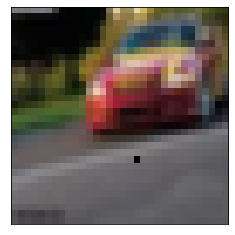

In [15]:
from inputtensorfi.helpers import utils
from inputtensorfi.manipulation.img.utils import build_perturb_image

perturbated_image = build_perturb_image(pixels)(data_test[0][image_id])
utils.plot_image(perturbated_image)